# Feature Engineering and EDA
The notebook goes through EDA  and Feature engineering process structured the following way:
1. Observations filtering: shortlisting only those amenities that are subjectively relevant to the scope of the project
1. Removing closed places
1. Feature Engineering: cuisine tags
1. Feature Engineering: other tags selection and aggregation
1. Getting Dummies from categorical data

______
### Data and libraries import

In [194]:
# Libraries import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd # geopandas to work with a GeoDataFrame
from shapely import wkt # for df -> gdf coordinates conversion

import folium  # mapping

In [244]:
# Reading data that was collected and preprocessed in the first part 
df = pd.read_csv('../data/POIs_raw.csv', index_col = 'Unnamed: 0', low_memory=False) # importing csv as a DataFrame

df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry']) # coordinates formatting to feed into GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry') # adding geometry

gdf.shape # checking the output

(13991, 616)

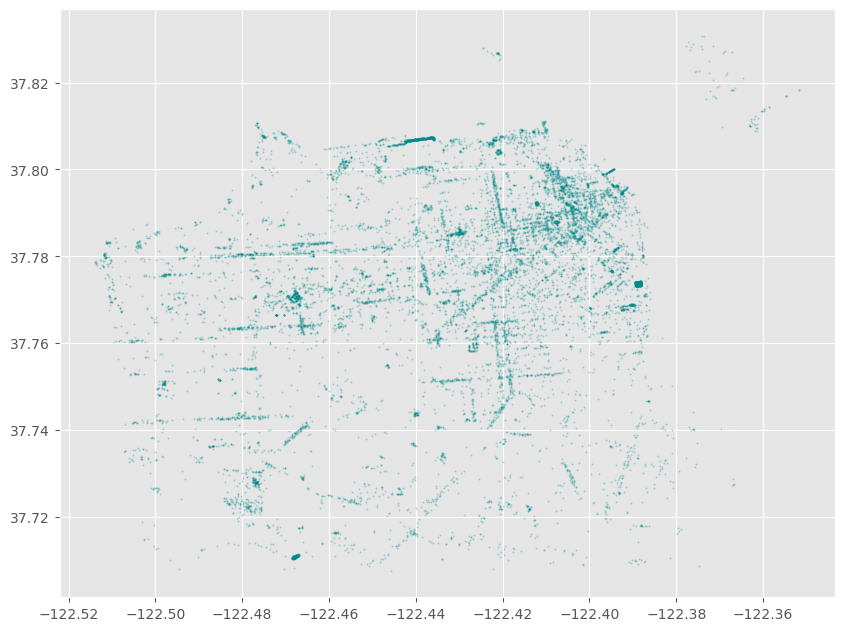

In [245]:
# Checking GeoDataFrame
gdf.plot(figsize = (10,10), color = 'darkcyan', marker = '.', markersize = 4, alpha = 0.2);

In [246]:
# Looking at attributes
gdf.head(3)

addr:city addr:housenumber addr:state    addr:street  \
61670779  San Francisco              530         CA  Haight Street   
61671096            NaN              547        NaN  Haight Street   
61671382            NaN              582        NaN  Haight Street   

                    alt_name amenity   branch contact:facebook  \
61670779  Woods Beer;Lowside     pub  Lowside      woodsbeerco   
61671096                 NaN     pub      NaN              NaN   
61671382                 NaN     pub      NaN              NaN   

         contact:instagram contact:twitter  ... was:addr:unit  \
61670779         woodsbeer       woodsbeer  ...           NaN   
61671096               NaN             NaN  ...           NaN   
61671382               NaN             NaN  ...           NaN   

         building:min_level wall skateboard terminal ways healthcare:for  \
61670779                NaN  NaN        NaN      NaN  NaN            NaN   
61671096                NaN  NaN        NaN      NaN  NaN            NaN   
61671382                NaN  NaN        NaN      NaN  NaN            NaN   

         community:wikidata addr:street_1 geom_type  
61670779                NaN           NaN      node  
61671096                NaN           NaN      node  
61671382                NaN           NaN      node  

[3 rows x 616 columns]

_________
### Observations selection: Amenity filtering
Semantic network of OSM is organized in a way so every amenity object has it's own category assigned, and then every category has their own range of different tags. Like `amenity: clock` will have tags `wall`, `digital`. Different amenities can share corresponding tags, like `restaraunt` and `cafe` share `diet: vegan`. 

I approached observations filtering in several logical parts: 
1) First, I removed amenites that were represented only once because they don't make any sense when calculating the similarirties between two clusters. 
2) I've also removed places that were marked as closed.
2) Then, I got rid of all the amenities that I considered to be outside of the project's scope - like parks, transit and bicyclists' infrastructure elements. 
Some of the examples: `['waste_basket', 'recycling', 'toilets', 'bench', 'drinking_water', 'bus_station', 'parking_entrance', 'car_sharing', 'taxi', 'bicycle_repair_station', 'bicycle parking']`. Same goes to the categories I personally don't think of as important ones when it comes to contributing to the place's vibe: post boxes, atms, clinics. But in the same time I've included post offices and banks because they are often located in historical buildings and parts of the town. 

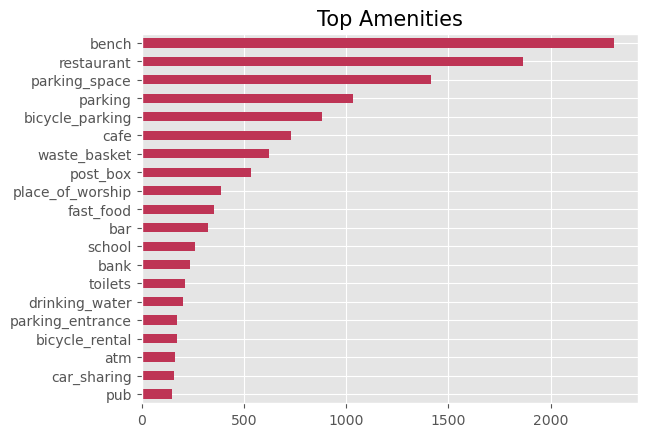

In [247]:
# Setting the plots' style
plt.style.use('ggplot')

# Top Amenities before filtering
gdf.amenity.value_counts(ascending = True)[-20:].plot(kind = 'barh', color = '#BE3455')
plt.title('Top Amenities', size = 15)
plt.savefig('../output/amenities_top.png', dpi = 300, bbox_inches = 'tight');

In [248]:
# Dropping amenity categories that are represented with only one point since they won't be very useful when finding similarities between different clusters
gdf = gdf.groupby('amenity').filter(lambda x: len(x) > 1)

# Dropping columns consisting of only NaNs
gdf = gdf.dropna(axis = 1, how = 'all')

# Dropping closed places
gdf = gdf.loc[gdf['opening_hours'] != 'closed']
gdf = gdf[gdf['opening_hours'] != 'closed "Temporarily closed"']

gdf.shape

(13936, 603)

In [249]:
# Manually chosen shortlist of subjectively relevant amenities
gdf_final = gdf[gdf.amenity.isin(['restaurant', 'cafe', 'place_of_worship', 'fast_food', 'bar', 
                                  'bank', 'bicycle_rental', 'pub',  'vending_machine', 'post_office', 
                                  'fuel', 'theatre', 'pharmacy', 'fountain', 'social_facility',
                                  'library', 'fire_station', 'community_centre', 'ice_cream',  'nightclub',
                                  'telephone',  'public_bookcase', 'arts_centre', 'cinema', 'clock', 
                                  'ferry_terminal', 'marketplace', 'food_court', 'social_centre', 'studio',
                                  'coworking_space', 'conference_centre', 'dojo', 'events_venue', 'music_school',
                                  'binoculars', 'smoking_area', 'mortuary', 'courthouse', 'animal_boarding', 
                                  'photo_booth', 'stripclub', 'animal_shelter', 'cooking_school', 'prison', 
                                  'swingerclub', 'karaoke_box', 'bureau_de_change', 'music_rehearsal_place'
                                ])]

# Dropping columns without any values
gdf_final = gdf_final.dropna(axis = 1, how = 'all')

gdf_final.shape

(5247, 466)

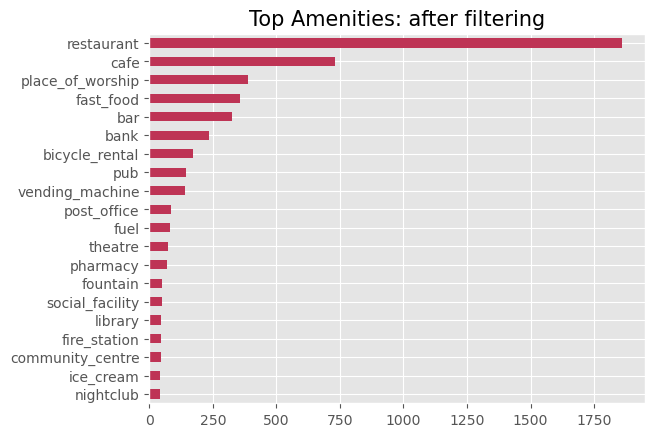

In [250]:
# Top Amenities after filtering
gdf_final.amenity.value_counts(ascending = True)[-20:].plot(kind = 'barh', color = '#BE3455')
plt.title('Top Amenities: after filtering', size = 15)
plt.savefig('../output/amenities_after_filtering.png', dpi = 300, bbox_inches = 'tight');

In [212]:
# How many categories are in a POIs shortlist
len(gdf_final.amenity.value_counts())

49

In [251]:
# Top Amenities
gdf_final.amenity.value_counts().head(15)

restaurant          1859
cafe                 730
place_of_worship     389
fast_food            356
bar                  324
bank                 234
bicycle_rental       171
pub                  146
vending_machine      140
post_office           85
fuel                  81
theatre               74
pharmacy              68
fountain              50
social_facility       49
Name: amenity, dtype: int64

______________
### EDA: Interactive map of shortlisted amenities

In [ ]:
# Removing all attributes except amenity and geometry for the sake of memory usage
gdf_fin_min = gdf_final[['amenity', 'geometry']]

# Color assignment to top categories that changed after filtering
gdf_fin_min['color'] = gdf_fin_min['amenity'].map({'restaurant': 'cadetblue',
                                                   'cafe': 'cadetblue',
                                                   'place_of_worship': 'pink',
                                                   'fast_food': 'lightblue',
                                                   'bar':  'blue',
                                                   'bank': 'darkpurple',
                                                   'bicycle_rental': 'darkred',
                                                   'pub': 'beige',
                                                   'vending_machine':'purple',
                                                   'post_office': 'white',
                                                   'fuel' : 'lightgreen',
                                                   'theatre': 'lightred',
                                                   'pharmacy':'darkgreen',
                                                   'fountain' : 'orange'})

# Filling non-top categories with lightgrey
gdf_fin_min.fillna(value='lightgray', inplace = True)

In [218]:
# Mapping shortlisted points

# Basemap
m1 = folium.Map(location = [37.7775, -122.416389], 
                tiles="Cartodb dark_matter",
                zoom_start=15, 
                min_zoom=12, 
                max_bounds=True) 

# Adding points
for lon, lat, col, amenity in zip(gdf_fin_min.geometry.x, gdf_fin_min.geometry.y, gdf_fin_min.color, gdf_fin_min.amenity):
    folium.CircleMarker([lat, lon], 
                        radius = 2,  
                        fill_color = col, 
                        fill=True, 
                        color=False, 
                        fill_opacity = 0.5, 
                        popup = amenity 
                       ).add_to(m1)    
    
m1.save('../output/POI_shortlist.html') # saving map

m1 # displaying map

______________
### Feature Engineering: Cuisine tags
Cuisine column is one of the most informative ones. The main challenge here was to split places with several tags to multiple columns to count them as tags per cluster later.

In [219]:
# How many places have multiple cuisine tags?
gdf_final['cuisine'].str.contains(';').value_counts()

False    1801
True      345
Name: cuisine, dtype: int64

In [ ]:
# Splitting cuisine tags to several columns so one column = one tag
cuisine = gdf_final['cuisine'].str.split(';', expand=True).copy()

# Creating a list of unique cuisine tags based on the first column
tags = list(cuisine[0].unique())

# Updating a list based on other seven columns
for i in range(1,9):
    for tag in cuisine[i]:
        if tag not in tags:
            tags.append(tag)
            
# Filling NaNs with zeros
cuisine.fillna(0, inplace = True)

# Creating columns dedicated to individual cuisine tags based on the first tag
for tag in tags[1:]: # skipping zero
    cuisine[tag] = cuisine[0].map(lambda i: 1 if i == tag else 0)

In [253]:
# Checking how cuisine dataframe looks after previous step
cuisine[cuisine[8] != 0]

0         1          2      3      4         5       6  \
8689758450  burger  sandwich  breakfast  asian  local  american  noodle   

                7      8  diner  ...  omelette  pinsa  shawarma  garlic  \
8689758450  bagel  donut      0  ...         0      0         0       0   

            waffle  napoletana  fried_cheese_sticks  modern  gyros  local  
8689758450       0           0                    0       0      0      0  

[1 rows x 176 columns]

/var/folders/33/gxsl6tm53sl1wjmxq6vld6c80000gn/T/ipykernel_17234/192438209.py:2: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sums = cuisine.sum()


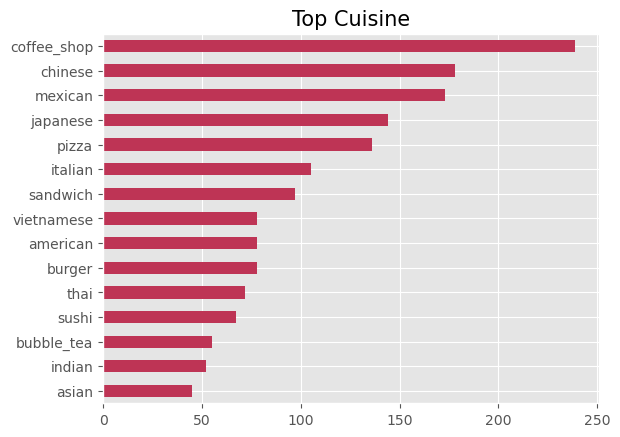

In [254]:
# Top cuisine tags
sums = cuisine.sum()
sums.sort_values()[-15:].plot(kind = 'barh', color = '#BE3455')

plt.title('Top Cuisine', size = 15)
plt.savefig('../output/cuisine_top.png', dpi = 300, bbox_inches = 'tight');

In [255]:
# Going through the rest of columns with cuisine tags to update one-hot encoded columns with ones
for num in range(1,9):
    for index in cuisine.index:
        if cuisine.loc[index, num] != 0:
            val = cuisine.loc[index, num]
            cuisine.loc[index,val] = 1
            
# Doublechecking if it worked corrrectly
cuisine.loc[8689758450,8]

'donut'

In [256]:
cuisine.loc[8689758450,'donut']

1

In [257]:
cuisine.loc[1119503897,'italian']

1

In [258]:
# Dropping initial columns
cuisine.drop(columns = [0, 1, 2, 3, 4, 5, 6, 7, 8,], inplace = True)
cuisine.head(3)

diner  coffee_shop  lebanese  steak  sandwich  pizza  thai  \
61670779        0            0         0      0         0      0     0   
61671096        0            0         0      0         0      0     0   
61671382        0            0         0      0         0      0     0   
61672275        0            0         0      0         0      0     0   
61673273        0            0         0      0         0      0     0   
...           ...          ...       ...    ...       ...    ...   ...   
1105933644      0            0         0      0         0      0     0   
1119498387      0            0         0      0         0      0     0   
1119503897      0            0         0      0         0      0     0   
1123730970      0            0         0      0         0      0     0   
1136875252      0            0         0      0         0      0     0   

            italian  persian  burger  ...  omelette  pinsa  shawarma  garlic  \
61670779          0        0       0  ...         0      0         0       0   
61671096          0        0       0  ...         0      0         0       0   
61671382          0        0       0  ...         0      0         0       0   
61672275          0        0       0  ...         0      0         0       0   
61673273          0        0       0  ...         0      0         0       0   
...             ...      ...     ...  ...       ...    ...       ...     ...   
1105933644        0        0       0  ...         0      0         0       0   
1119498387        0        0       0  ...         0      0         0       0   
1119503897        1        0       0  ...         0      0         0       0   
1123730970        0        0       0  ...         0      0         0       0   
1136875252        0        0       1  ...         0      0         0       0   

            waffle  napoletana  fried_cheese_sticks  modern  gyros  local  
61670779         0           0                    0       0      0      0  
61671096         0           0                    0       0      0      0  
61671382         0           0                    0       0      0      0  
61672275         0           0                    0       0      0      0  
61673273         0           0                    0       0      0      0  
...            ...         ...                  ...     ...    ...    ...  
1105933644       0           0                    0       0      0      0  
1119498387       0           0                    0       0      0      0  
1119503897       0           0                    0       0      0      0  
1123730970       0           0                    0       0      0      0  
1136875252       0           0                    0       0      0      0  

[5247 rows x 167 columns]

In [259]:
# Checking data types
cuisine.dtypes

diner                  int64
coffee_shop            int64
lebanese               int64
steak                  int64
sandwich               int64
                       ...  
napoletana             int64
fried_cheese_sticks    int64
modern                 int64
gyros                  int64
local                  int64
Length: 167, dtype: object

In [260]:
# Saving matrix of cuisine tags to a csv for a future use
cuisine.to_csv('../data/cuisine.csv')

________________
### Feature engineering: Filtering other tags
Next step was to focus on important tags only because 466 columns is apparently too many. I reviewed every column for any tags I might use to calculate similarities between different city clusters. For those columns which I considered handy in the scope of the project, I removed minor subcategories - especially those that were only present once. And some columns required manual dummyfying, like converting `yes` and `partial` to ones so they can be summed up later per cluster.

In [261]:
gdf_final.shape

(5247, 466)

In [262]:
# Aggregating categories implying presence of something and removing minor tags
gdf_final.shop.replace(['coffee','gift','pastry','chocolate','laundry','winery','plants','yes',
                                               'cannabis','mobile_phone','butcher','vacant','mall'], np.nan, inplace = True)

gdf_final['craft'].replace(['glaziery','key_cutter','caterer','cook'], np.nan, inplace = True)

gdf_final['religion'].replace(['bahai','unitarian_universalist','tenrikyo','perfect_liberty', 'shinto'], np.nan, inplace = True)

gdf_final['denomination'].replace(['united_methodist','ukrainian_orthodox','nondenominational','la_luz_del_mundo','won',
                                'swedenborgian','african_orthodox','modern_orthodox','free_evangelical','scientist',
                                'protestant','konkokyo','soka_gakkai','quaker','salvation_army',
                                'christian_reformed_church_in_north_america','Masonic','church_of_christ','greek_orthodox',
                                'united_church_of_christ','mormon','jodo_shinshu'], np.nan, inplace = True)

gdf_final['tourism'].replace(['information'], np.nan, inplace = True)

gdf_final['leisure'].replace(['stadium','sports_centre','bowling_alley'], np.nan, inplace = True)

gdf_final['studio'].replace(['arts and language'], np.nan, inplace = True)

In [263]:
# Leaving only 24/7 in open hours and renaming column for better clarity
gdf_final['opening_hours'] = gdf_final['opening_hours'].map(lambda i: 1 if i == '24/7' else 0)
gdf_final.rename(columns={'opening_hours': '24-7'}, inplace = True)

# Drinks
gdf_final['drink:beer'] = gdf_final['drink:beer'].map(lambda i: 1 if (i == 'yes' or i == 'served') else 0)
gdf_final['drink:wine'] = gdf_final['drink:wine'].map(lambda i: 1 if i == 'yes' else 0)
gdf_final['drink:sake'] = gdf_final['drink:sake'].map(lambda i: 1 if i == 'yes' else 0)
gdf_final['drink:whisky'] = gdf_final['drink:whisky'].map(lambda i: 1 if i == 'yes' else 0)
gdf_final['drink:coffee'] = gdf_final['drink:coffee'].map(lambda i: 1 if (i == 'yes' or i == 'takeaway') else 0)
gdf_final['drink:espresso'] = gdf_final['drink:espresso'].map(lambda i: 1 if i == 'yes' else 0)
gdf_final['drink:tea'] = gdf_final['drink:tea'].map(lambda i: 1 if i == 'yes' else 0)
gdf_final['drink:hot_chocolate'] = gdf_final['drink:hot_chocolate'].map(lambda i: 1 if i == 'yes' else 0)
gdf_final['cocktails'] = gdf_final['cocktails'].map(lambda x: 1 if x == 'yes' else 0)

# Dietary restrictions
gdf_final['diet:vegetarian'] = gdf_final['diet:vegetarian'].map(lambda x: 1 if x in ['yes', 'only'] else 0)
gdf_final['diet:vegan'] = gdf_final['diet:vegan'].map(lambda x: 1 if x in ['yes', 'only'] else 0)
gdf_final['diet:gluten_free'] = gdf_final['diet:gluten_free'].map(lambda x: 1 if x == 'yes' else 0)
gdf_final['diet:halal'] = gdf_final['diet:halal'].map(lambda x: 1 if x in ['yes', 'only'] else 0)
gdf_final['diet:kosher'] = gdf_final['diet:kosher'].map(lambda x: 1 if x == 'yes' else 0)

# Aggregating outdoor seating to binaries
gdf_final['outdoor_seating'] = gdf_final['outdoor_seating'].replace(['yes', 'sidewalk', 'parklet', 'patio', 'limited', 'covid19 parklet'], 1)
gdf_final['outdoor_seating'] = gdf_final['outdoor_seating'].map(lambda i: 0 if i != 1 else 1)

# Other popular tags I've found handy for the project
gdf_final['bar'] = gdf_final['bar'].map(lambda x: 1 if x in ['yes', 'wine_bar'] else 0)
gdf_final['brewery'] = gdf_final['brewery'].map(lambda x: 1 if x in ['yes','yes;various','Sequoia Sake'] else 0)
gdf_final['happy_hours'] = gdf_final['happy_hours'].map(lambda i: 1 if len(str(i)) > 5 else 0)
gdf_final['taqueria'] = gdf_final['taqueria'].map(lambda x: 1 if x == 'yes' else 0)
gdf_final['wheelchair'] = gdf_final['wheelchair'].map(lambda x: 1 if x in ['yes', 'limited', 'partial'] else 0)
gdf_final['lgbtq'] = gdf_final['lgbtq'].map(lambda x: 1 if x == 'primary' else 0)
gdf_final['indoor_seating'] = gdf_final['indoor_seating'].map(lambda i: 1 if i == 'yes' else 0)
gdf_final['live_music'] = gdf_final['live_music'].map(lambda x: 1 if x in ['yes', 'Sa, Su'] else 0)
gdf_final['karaoke'] = gdf_final['karaoke'].map(lambda x: 1 if x == 'yes' else 0)
gdf_final['historic'] = gdf_final['historic'].map(lambda x: 1 if x in ['building','yes','church','Landmark','landmark'] else 0)
gdf_final['service_times'] = gdf_final['service_times'].map(lambda i: 1 if len(str(i)) > 5 else 0)
gdf_final['dog'] = gdf_final['dog'].map(lambda x: 1 if x == 'yes' else 0)

# Aggregating theatre genres to the most popular tag - stand up comedy
gdf_final['theatre:genre'] = gdf_final['theatre:genre'].map(lambda x: 1 if x == 'stand_up_comedy' else 0)
gdf_final.rename(columns={'theatre:genre': 'stand_up_comedy'}, inplace = True)

# Payments with crypto
gdf_final['payment:bitcoincash'] = gdf_final['payment:bitcoincash'].map(lambda x: 1 if x == 'yes' else 0)
gdf_final['payment:bitcoin'] = gdf_final['payment:bitcoin'].map(lambda x: 1 if x == 'yes' else 0)

# Aggregating sports to billiard only
gdf_final['sport'] = gdf_final['sport'].map(lambda x: 1 if x == 'billiards' else 0)
gdf_final.rename(columns={'sport': 'billiards'}, inplace = True)

In [264]:
# Dummifying columns that weren't dummified yet, but need to be included into recommendations
gdf_2 = gdf_final[['amenity','shop', 'religion', 'denomination', 'craft', 'tourism', 'leisure', 'studio']]
gdf_2

amenity shop religion denomination craft tourism leisure  \
61670779               pub  NaN      NaN          NaN   NaN     NaN     NaN   
61671096               pub  NaN      NaN          NaN   NaN     NaN     NaN   
61671382               pub  NaN      NaN          NaN   NaN     NaN     NaN   
61672275               pub  NaN      NaN          NaN   NaN     NaN     NaN   
61673273               pub  NaN      NaN          NaN   NaN     NaN     NaN   
...                    ...  ...      ...          ...   ...     ...     ...   
1105933644        fountain  NaN      NaN          NaN   NaN     NaN     NaN   
1119498387  bicycle_rental  NaN      NaN          NaN   NaN     NaN     NaN   
1119503897      restaurant  NaN      NaN          NaN   NaN     NaN     NaN   
1123730970  bicycle_rental  NaN      NaN          NaN   NaN     NaN     NaN   
1136875252       fast_food  NaN      NaN          NaN   NaN     NaN     NaN   

           studio  
61670779      NaN  
61671096      NaN  
61671382      NaN  
61672275      NaN  
61673273      NaN  
...           ...  
1105933644    NaN  
1119498387    NaN  
1119503897    NaN  
1123730970    NaN  
1136875252    NaN  

[5247 rows x 8 columns]

In [265]:
# Dummyfying everything
gdf_2_dummies = pd.get_dummies(gdf_2)
gdf_2_dummies.head(1)

amenity_animal_boarding  amenity_animal_shelter  \
61670779                        0                       0   

          amenity_arts_centre  amenity_bank  amenity_bar  \
61670779                    0             0            0   

          amenity_bicycle_rental  amenity_binoculars  \
61670779                       0                   0   

          amenity_bureau_de_change  amenity_cafe  amenity_cinema  ...  \
61670779                         0             0               0  ...   

          denomination_zen  craft_brewery  craft_winery  tourism_artwork  \
61670779                 0              0             0                0   

          tourism_attraction  tourism_viewpoint  leisure_amusement_arcade  \
61670779                   0                  0                         0   

          leisure_dance  studio_radio  studio_television  
61670779              0             0                  0  

[1 rows x 92 columns]

In [235]:
# Checking validity
gdf_2_dummies[gdf_2_dummies.shop_tea > 0]

amenity_animal_boarding  amenity_animal_shelter  \
365489492                         0                       0   
4631982800                        0                       0   

            amenity_arts_centre  amenity_bank  amenity_bar  \
365489492                     0             0            0   
4631982800                    0             0            0   

            amenity_bicycle_rental  amenity_binoculars  \
365489492                        0                   0   
4631982800                       0                   0   

            amenity_bureau_de_change  amenity_cafe  amenity_cinema  ...  \
365489492                          0             1               0  ...   
4631982800                         0             1               0  ...   

            denomination_zen  craft_brewery  craft_winery  tourism_artwork  \
365489492                  0              0             0                0   
4631982800                 0              0             0                0   

            tourism_attraction  tourism_viewpoint  leisure_amusement_arcade  \
365489492                    0                  0                         0   
4631982800                   0                  0                         0   

            leisure_dance  studio_radio  studio_television  
365489492               0             0                  0  
4631982800              0             0                  0  

[2 rows x 92 columns]

In [266]:
# Putting it all together
gdf_processed = gdf_final[['geometry', 'name', 'amenity', 'addr:street',
                           'drink:beer', 'drink:wine', 'drink:sake', 'drink:coffee', 'drink:tea','drink:espresso', 'drink:whisky', 'drink:hot_chocolate',
                           'cocktails', 'diet:vegetarian', 'diet:vegan', 'diet:halal', 'diet:kosher', 'diet:gluten_free', 'bar', 'taqueria', 'wheelchair', 
                           'indoor_seating', 'brewery', 'dog', 'historic', 'lgbtq', 'live_music', 'karaoke', 'payment:bitcoincash', 'payment:bitcoin', '24-7', 
                           'billiards', 'outdoor_seating', 'stand_up_comedy', 'happy_hours', 'service_times']]

gdf_processed = pd.concat([gdf_processed, gdf_2_dummies, cuisine], axis = 1)
gdf_processed

geometry           name         amenity  \
61670779    POINT (-122.43102 37.77214)  Woods Lowside             pub   
61671096    POINT (-122.43122 37.77191)       Toronado             pub   
61671382    POINT (-122.43176 37.77205)      Molotov's             pub   
61672275    POINT (-122.43142 37.77189)        Noc Noc             pub   
61673273    POINT (-122.43326 37.77186)   Danny Coyles             pub   
...                                 ...            ...             ...   
1105933644  POINT (-122.39863 37.78379)            NaN        fountain   
1119498387  POINT (-122.39692 37.77794)     Bay Wheels  bicycle_rental   
1119503897  POINT (-122.42180 37.77819)           Baia      restaurant   
1123730970  POINT (-122.44524 37.77116)     Bay Wheels  bicycle_rental   
1136875252  POINT (-122.40815 37.78505)    Burger King       fast_food   

              addr:street  drink:beer  drink:wine  drink:sake  drink:coffee  \
61670779    Haight Street           1           1           0             0   
61671096    Haight Street           0           0           0             0   
61671382    Haight Street           0           0           0             0   
61672275    Haight Street           0           0           0             0   
61673273    Haight Street           0           0           0             0   
...                   ...         ...         ...         ...           ...   
1105933644            NaN           0           0           0             0   
1119498387            NaN           0           0           0             0   
1119503897   Grove Street           0           1           0             0   
1123730970            NaN           0           0           0             0   
1136875252            NaN           0           0           0             0   

            drink:tea  drink:espresso  ...  omelette  pinsa  shawarma  garlic  \
61670779            0               0  ...         0      0         0       0   
61671096            0               0  ...         0      0         0       0   
61671382            0               0  ...         0      0         0       0   
61672275            0               0  ...         0      0         0       0   
61673273            0               0  ...         0      0         0       0   
...               ...             ...  ...       ...    ...       ...     ...   
1105933644          0               0  ...         0      0         0       0   
1119498387          0               0  ...         0      0         0       0   
1119503897          0               0  ...         0      0         0       0   
1123730970          0               0  ...         0      0         0       0   
1136875252          0               0  ...         0      0         0       0   

            waffle  napoletana  fried_cheese_sticks  modern  gyros  local  
61670779         0           0                    0       0      0      0  
61671096         0           0                    0       0      0      0  
61671382         0           0                    0       0      0      0  
61672275         0           0                    0       0      0      0  
61673273         0           0                    0       0      0      0  
...            ...         ...                  ...     ...    ...    ...  
1105933644       0           0                    0       0      0      0  
1119498387       0           0                    0       0      0      0  
1119503897       0           0                    0       0      0      0  
1123730970       0           0                    0       0      0      0  
1136875252       0           0                    0       0      0      0  

[5247 rows x 295 columns]

In [267]:
# Checking if types are correct - there's no string columns. Did this by using a list comprehension, here's a short portion of it
gdf_processed.dtypes

geometry               geometry
name                     object
amenity                  object
addr:street              object
drink:beer                int64
                         ...   
napoletana                int64
fried_cheese_sticks       int64
modern                    int64
gyros                     int64
local                     int64
Length: 295, dtype: object

In [268]:
# Saving processed data 
gdf_processed.to_csv('../data/POIs_processed.csv')

The notebook goes through narrowing down the OSM data for the project purpose - to find "vibe" similarities between different parts of the town. After feature engineering and filtering, the number of places/observations dropped from 13991 to 5247. Also, only most important and informative tags left, being converted to binary format so they can be summed up during the next part of the project: clustering.